In [1]:
import os
from dotenv import load_dotenv
import warnings
import mysql.connector
from mysql.connector import Error
warnings.filterwarnings("ignore")

## connecting to mysql database

In [2]:
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import sessionmaker

# Define your MySQL database configuration
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'password',
    'database': 'test_raw_schema',
    'schema': 'test_raw_schema'
}

# Create the SQLAlchemy DATABASE_URL connection string
DATABASE_URL = f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create the SQLAlchemy engine
engine = create_engine(DATABASE_URL)

# Set up a sessionmaker bound to the engine
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)


### Retreiving the schema of the tables in the database

In [3]:
def get_database_schema(engine):
    """Retrieve the schema details for all tables in the database."""
    inspector = inspect(engine)
    schema_details = ""

    # Get all tables without specifying a schema
    tables = inspector.get_table_names()
    for table_name in tables:
        schema_details += f"Table: {table_name}\n"
        
        # Get column details for each table
        columns = inspector.get_columns(table_name)
        for column in columns:
            col_name = column["name"]
            col_type = str(column["type"])
            details = f"- {col_name}: {col_type}"
            
            # Check for primary keys
            if column.get("primary_key"):
                details += ", Primary Key"
            
            # Check for foreign keys
            foreign_keys = inspector.get_foreign_keys(table_name)
            for fk in foreign_keys:
                if col_name == fk['constrained_columns'][0]:
                    details += f", Foreign Key to {fk['referred_table']}.{fk['referred_columns'][0]}"
            
            schema_details += details + "\n"
        schema_details += "\n"

    print("Database Schema Retrieved Successfully")
    return schema_details

# Retrieve and print the schema
schema_info = get_database_schema(engine)
print(schema_info)


Database Schema Retrieved Successfully
Table: brands
- id: VARCHAR(255)
- barcode: VARCHAR(255)
- brandCode: VARCHAR(255)
- category: VARCHAR(255)
- categoryCode: VARCHAR(255)
- cpg_id: VARCHAR(255)
- cpg_ref: VARCHAR(255)
- name: VARCHAR(255)
- topBrand: VARCHAR(255)

Table: receipts
- id: VARCHAR(255)
- bonusPointsEarned: FLOAT
- bonusPointsEarnedReason: VARCHAR(255)
- createDate: DATETIME
- dateScanned: DATETIME
- finishedDate: DATETIME
- modifyDate: DATETIME
- pointsAwardedDate: DATETIME
- pointsEarned: INTEGER
- purchaseDate: DATETIME
- purchasedItemCount: INTEGER
- rewardsReceiptStatus: VARCHAR(255)
- totalSpent: FLOAT
- userId: VARCHAR(255)
- barcode: VARCHAR(255)
- brandCode: VARCHAR(255)
- competitiveProduct: VARCHAR(255)
- competitorRewardsGroup: VARCHAR(255)
- deleted: VARCHAR(255)
- description: TEXT
- discountedItemPrice: FLOAT
- finalPrice: FLOAT
- itemNumber: VARCHAR(255)
- itemPrice: FLOAT
- metabriteCampaignId: VARCHAR(255)
- needsFetchReview: VARCHAR(255)
- needsFetch

### Retreive the metadata of the tables to use it for LangGragh SQL Agent

In [4]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langchain_core.runnables.config import RunnableConfig

In [5]:
# Initialize the OpenAI model
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(api_key=openai_api_key, temperature=0)


### Define the ```AgentState``` Class

In [6]:
from typing import Annotated
from typing_extensions import TypedDict


class AgentState(TypedDict):
    question: Annotated[str, "The user's question or prompt."]
    sql_query: str
    query_result: str
    query_rows: list
    attempts: int
    relevance: str
    sql_error: bool


from typing_extensions import TypedDict

class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    #current_user: str
    attempts: int
    relevance: str
    sql_error: bool

- This Agentstate class is used to define the structure of a dictionary that will keep track of the agent's state throughout the workflow.
- Each key in ```AgentState``` represents a piece of data the agent will manage, including:

1. ```question```: Stores the user's natural language question.
2. ```sql_query```: Holds the SQL query generated from the natural language question.
3. ```query_result```: Stores the final, formatted result of the SQL query execution, whether it's data output or an error message.
4. ```query_rows```: Holds the rows of data fetched by the query (if applicable).
5. ```attempts```: Tracks the number of times the agent has tried to generate a query, helping in limiting retries.
6. ```relevance```: Indicates whether the question is relevant to the database schema.
7. ```sql_error```: A boolean flag to indicate if an error occurred during SQL execution.

In [8]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatOpenAI(api_key=openai_api_key, temperature=0)
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm  # Combines the prompt and the language model
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")  # Print and Return the Result
    return state


- The above function updates state["relevance"] to either "relevant" or "not_relevant", which guides subsequent workflow steps on whether to proceed with SQL generation or handle the question differently.

### Code to convert natural language to SQL qery using LLM

In [9]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]    # Gets the user’s question from the state
    #current_user = state["current_user"]    # Retrieves the user’s name for personalization
    schema = get_database_schema(engine) # Retrieves the database schema, providing context for SQL generation
    print(f"Converting question to SQL :{question}")

    # Prepare the Prompt
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.

For example, alias 'receipts.totalSpent' as 'totalSpent' and 'brands.brandCode' as 'brandCode'.
""".format(schema=schema)
    
    #Set Up the Prompt and Model
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state


In [10]:
def execute_sql(state: AgentState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")

                #header = ", ".join(columns)
                # Custom formatting for readability based on table structure
                formatted_rows = []
                for row in state["query_rows"]:
                    if "barcode" in row and "brandCode" in row and "name" in row:
                        # Likely a row from the brands table
                        formatted_rows.append(f"Brand: {row.get('name')} (Code: {row.get('brandCode')}, Barcode: {row.get('barcode')})")
                    
                    elif "id" in row and "totalSpent" in row and "pointsEarned" in row:
                        # Likely a row from the receipts table
                        formatted_rows.append(f"Receipt ID: {row.get('id')}, Total Spent: ${row.get('totalSpent')}, Points Earned: {row.get('pointsEarned')}")
                    
                    elif "id" in row and "state" in row and "active" in row:
                        # Likely a row from the users table
                        status = "Active" if row.get("active") == "True" else "Inactive"
                        formatted_rows.append(f"User ID: {row.get('id')}, State: {row.get('state')}, Status: {status}")
                    
                    else:
                        # Generic format for rows with unidentified structure
                        formatted_rows.append(", ".join([f"{key}: {value}" for key, value in row.items()]))

                # Join all formatted rows into a single output string
                formatted_result = "\n".join(formatted_rows)

                # Custom formatting for readability based on table structure
                #data = "; ".join([f"{row.get('food_name', row.get('name'))} for ${row.get('price', row.get('food_price'))}" for row in state["query_rows"]])
                #formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."

            # Update the state with the formatted result
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state


In [11]:
def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    result = state["query_result"]
    #current_user = state["current_user"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    system = """You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. Start the response with a friendly greeting that includes the user's name.
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, starting with 'Hello User,' informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no results
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello User,' and mention that there are no records found."""
                    ),
                ]
            )
        else:
            # Handle displaying query results
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello User,' and list each item and its details. For example: 'Hello Bob, you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, starting with 'Hello User,' confirming that your request has been successfully processed."""
                ),
            ]
        )

    llm = ChatOpenAI(temperature=0)
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state


In [12]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = ChatOpenAI(temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state


In [13]:
def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = ChatOpenAI(temperature=0.7)
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state


In [14]:
def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state


In [15]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

In [16]:
def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

In [17]:
def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

In [18]:
workflow = StateGraph(AgentState)

#workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)

#workflow.add_edge("get_current_user", "check_relevance")
workflow.add_edge("check_relevance","convert_to_sql")

workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

#workflow.set_entry_point("get_current_user")
workflow.set_entry_point("check_relevance")

app = workflow.compile()

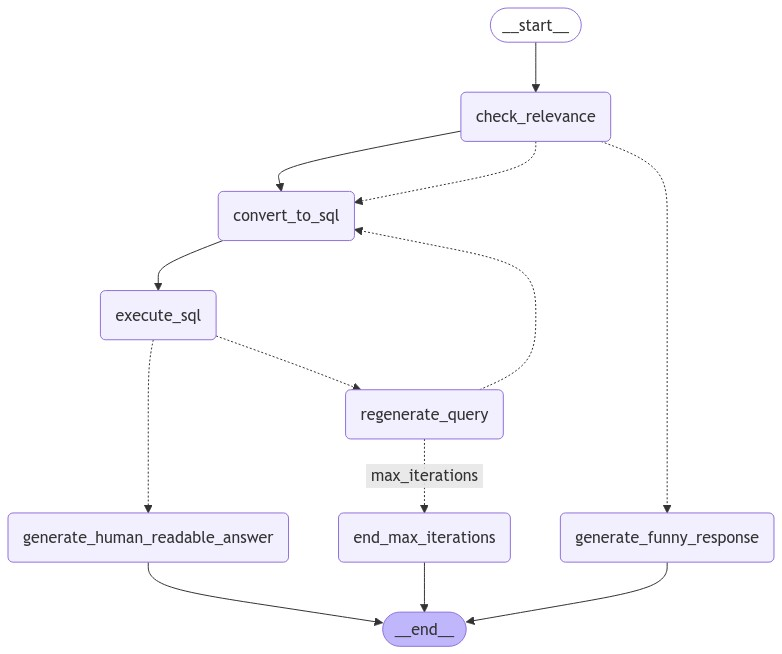

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

#### Visualizing the graph using Networkx package

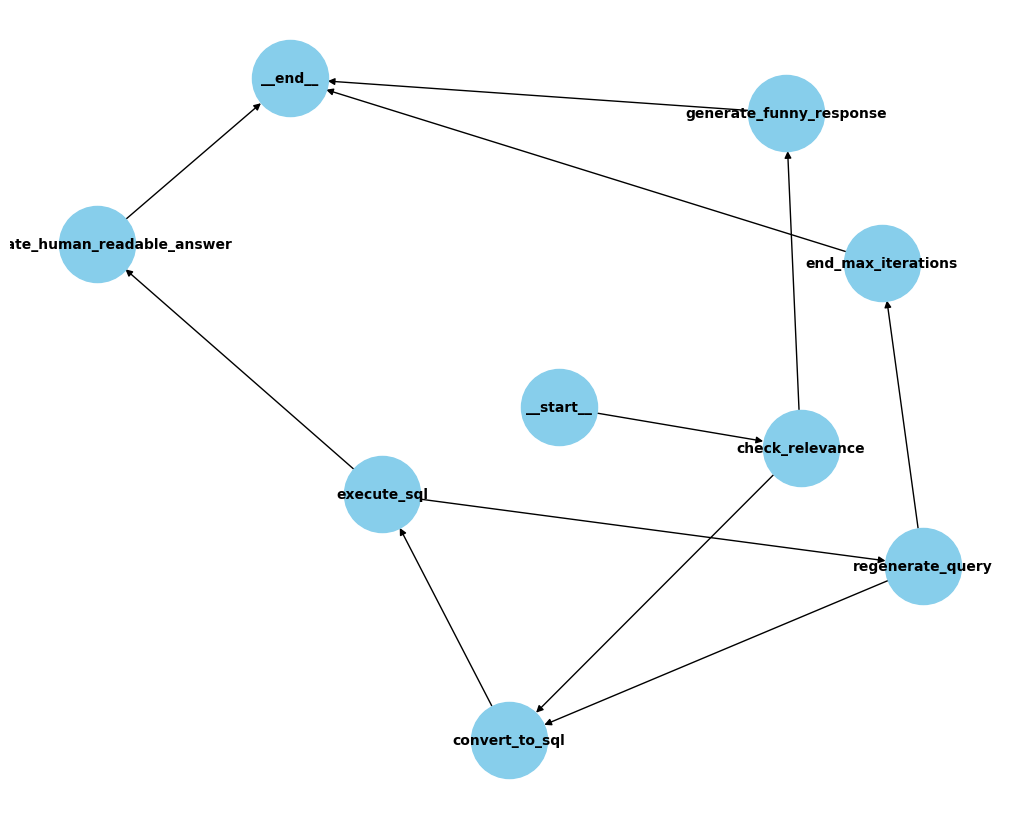

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Generate nodes and edges from the LangGraph graph object
graph = app.get_graph(xray=True)

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes to the NetworkX graph
for node in graph.nodes:
    G.add_node(node)  # Add node directly if it's a string

# Add edges to the NetworkX graph
for edge in graph.edges:
    G.add_edge(edge[0], edge[1])  # Assume edge is a tuple (source, target)

# Draw the NetworkX graph
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    with_labels=True,
    node_size=3000,
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
plt.show()


In [22]:
user_question_3 = "Show me all the brand categories you have, join different tables to get the result"
result_3 = app.invoke({"question": user_question_3, "attempts": 0})
print("Result:", result_3["query_result"])

Database Schema Retrieved Successfully
Checking relevance of the question: Show me all the brand categories you have, join different tables to get the result
Relevance determined: relevant
Database Schema Retrieved Successfully
Converting question to SQL :Show me all the brand categories you have, join different tables to get the result
Generated SQL query: SELECT DISTINCT b.category AS category
FROM brands b
JOIN receipts r ON b.brandCode = r.brandCode
JOIN users u ON r.userId = u.id
Executing SQL query: SELECT DISTINCT b.category AS category
FROM brands b
JOIN receipts r ON b.brandCode = r.brandCode
JOIN users u ON r.userId = u.id
Raw SQL Query Result: [{'category': 'Canned Goods & Soups'}, {'category': 'Snacks'}, {'category': 'Frozen'}, {'category': 'Condiments & Sauces'}, {'category': 'Dairy'}, {'category': 'Grocery'}, {'category': 'Breakfast & Cereal'}, {'category': 'Beverages'}, {'category': 'Baking'}, {'category': 'Deli'}, {'category': 'Bread & Bakery'}, {'category': 'Household'